In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

from tqdm import tqdm

# Data Cleaning

Source: [Google Trends](https://trends.google.com/trends/)

In [2]:
data_root = Path("data")

In [3]:
unemp = pd.read_csv(data_root / "unemp.csv")
unemp

,DATE,LRUNTTTTCAM156S
0,2004-01-01,7.3
1,2004-02-01,7.3
2,2004-03-01,7.3
3,2004-04-01,7.2
4,2004-05-01,7.1
...,...,...
175,2018-08-01,6.0
176,2018-09-01,5.8
177,2018-10-01,5.7
178,2018-11-01,5.7


In [4]:
unemp.columns = ["Date", "Unemployment"]

In [5]:
unemp.dtypes

Date             object
Unemployment    float64
dtype: object

In [10]:
unemp["Date"] = unemp["Date"].apply(pd.to_datetime)
unemp.set_index("Date", inplace=True)
unemp

,Unemployment
Date,
2004-01-01,7.3
2004-02-01,7.3
2004-03-01,7.3
2004-04-01,7.2
2004-05-01,7.1
...,...
2018-08-01,6.0
2018-09-01,5.8
2018-10-01,5.7


In [11]:
unemp.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='Date', length=180, freq=None)

In [14]:
trend_files = data_root.glob("multiTimeline*.csv")
trend_files

<generator object Path.glob at 0x7f9134662420>

In [15]:
dfs = list()
for trend_file in trend_files:
    df = (
        pd.read_csv(trend_file, 
                    skiprows=1, 
                    converters={"Month": pd.to_datetime})
        .rename({"Month": "Date"}, axis=1)
        .rename(lambda colname: colname.replace(": (Canada)", ''), axis=1)
        .set_index("Date")
    )
    dfs.append(df)
df = pd.concat(dfs, axis=1)
del dfs # remove unnecessary dataframes
df

,job postings,food prices,how to write a resume,housing,recession,layoffs,layoff,jobs,what to do when fired,employment insurance
Date,,,,,,,,,,
2004-01-01,93,57,100,84,5,7,14,47,0,86
2004-02-01,100,72,51,88,0,7,0,48,0,84
2004-03-01,84,58,61,91,7,0,24,49,0,84
2004-04-01,85,0,82,86,8,13,17,49,0,87
2004-05-01,95,60,72,88,8,7,22,48,0,82
...,...,...,...,...,...,...,...,...,...,...
2018-08-01,34,74,15,69,12,11,17,71,0,23
2018-09-01,32,65,17,62,16,13,17,69,5,19
2018-10-01,28,64,17,64,18,15,18,70,0,19


In [16]:
trend = unemp.join(df, how="inner")
del unemp
del df
trend

,Unemployment,job postings,food prices,how to write a resume,housing,recession,layoffs,layoff,jobs,what to do when fired,employment insurance
Date,,,,,,,,,,,
2004-01-01,7.3,93,57,100,84,5,7,14,47,0,86
2004-02-01,7.3,100,72,51,88,0,7,0,48,0,84
2004-03-01,7.3,84,58,61,91,7,0,24,49,0,84
2004-04-01,7.2,85,0,82,86,8,13,17,49,0,87
2004-05-01,7.1,95,60,72,88,8,7,22,48,0,82
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,6.0,34,74,15,69,12,11,17,71,0,23
2018-09-01,5.8,32,65,17,62,16,13,17,69,5,19
2018-10-01,5.7,28,64,17,64,18,15,18,70,0,19


## Quick Visualization

In [17]:
target = "Unemployment"

In [18]:
# normalize data
trend_norm = (trend - trend.mean()) / trend.std()
trend_norm.mean(), trend_norm.std()

(Unemployment            -2.102022e-15
 job postings            -3.947460e-17
 food prices             -1.578984e-16
 how to write a resume    7.894919e-17
 housing                 -4.736952e-16
 recession                6.908054e-17
 layoffs                 -5.921189e-17
 layoff                  -1.134895e-16
 jobs                     2.368476e-16
 what to do when fired    3.824102e-17
 employment insurance     7.894919e-17
 dtype: float64,
 Unemployment             1.0
 job postings             1.0
 food prices              1.0
 how to write a resume    1.0
 housing                  1.0
 recession                1.0
 layoffs                  1.0
 layoff                   1.0
 jobs                     1.0
 what to do when fired    1.0
 employment insurance     1.0
 dtype: float64)

In [19]:
trend_norm

,Unemployment,job postings,food prices,how to write a resume,housing,recession,layoffs,layoff,jobs,what to do when fired,employment insurance
Date,,,,,,,,,,,
2004-01-01,0.425400,2.284453,0.424655,3.809456,1.087954,-0.700461,-0.839633,-0.595900,-0.951665,-0.437465,1.852411
2004-02-01,0.425400,2.707873,1.319015,0.874498,1.411777,-1.003399,-0.839633,-1.734390,-0.880498,-0.437465,1.757267
2004-03-01,0.425400,1.740055,0.484279,1.473469,1.654644,-0.579286,-1.256637,0.217307,-0.809331,-0.437465,1.757267
2004-04-01,0.286933,1.800544,-2.973913,2.731308,1.249865,-0.518698,-0.482202,-0.351938,-0.809331,-0.437465,1.899983
2004-05-01,0.148467,2.405430,0.603527,2.132337,1.411777,-0.518698,-0.839633,0.054666,-0.880498,-0.437465,1.662122
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,-1.374665,-1.284375,1.438263,-1.281798,-0.126381,-0.276347,-0.601345,-0.351938,0.756350,-0.437465,-1.144642
2018-09-01,-1.651597,-1.405352,0.901647,-1.162004,-0.693070,-0.033996,-0.482202,-0.351938,0.614016,0.001953,-1.334931
2018-10-01,-1.790064,-1.647306,0.842023,-1.162004,-0.531159,0.087179,-0.363058,-0.270617,0.685183,-0.437465,-1.334931


<Axes: xlabel='Date'>

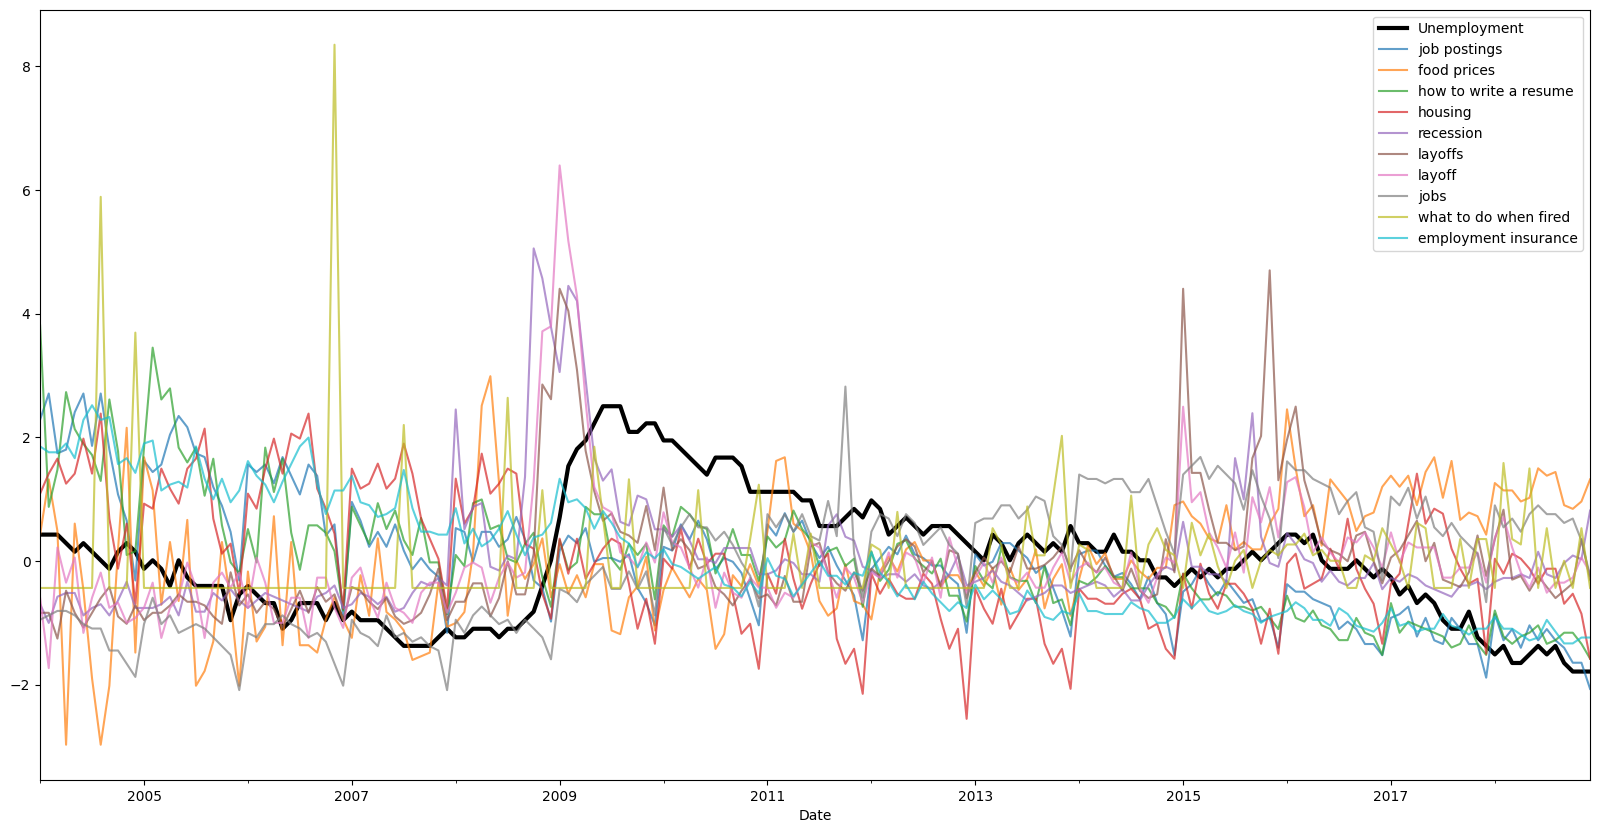

In [20]:
ax = trend_norm[[target]].plot(c="black", lw=3)
trend_norm.drop(target, axis=1).plot(alpha=0.7, figsize=(20,10), ax=ax)

# Model Training

In [22]:
def mse_gs_cv(model, params, X, y, cv=None):
    grid_search = GridSearchCV(model, params, cv=cv, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)
    res = grid_search.cv_results_
    return pd.DataFrame(
        {p_name: res[f"param_{p_name}"].data for p_name in params.keys()}
        | {"score": res["mean_test_score"]}
    ), grid_search

def sort_lists(lists, based_on=0):
    return zip(*sorted(zip(*lists), key=lambda pair: pair[based_on]))

In [23]:
# add lag unemployment and drop first n rows
l = 1
trend_norm["Lag Unemployment"] = trend_norm[target].shift(l)
trend_norm = trend_norm.iloc[l:,:]
trend = trend.iloc[l:,:]

In [36]:
feats_to_drop = [target]# + ["Lag Unemployment"] 

feature_names = trend_norm.drop(feats_to_drop, axis=1).columns

X = trend_norm.drop(feats_to_drop, axis=1).values
y = trend[target].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [38]:
# How good/bad is the mean?
mean_squared_error(y_test, np.full(len(y_test), y_train.mean()))

0.6058799163387044

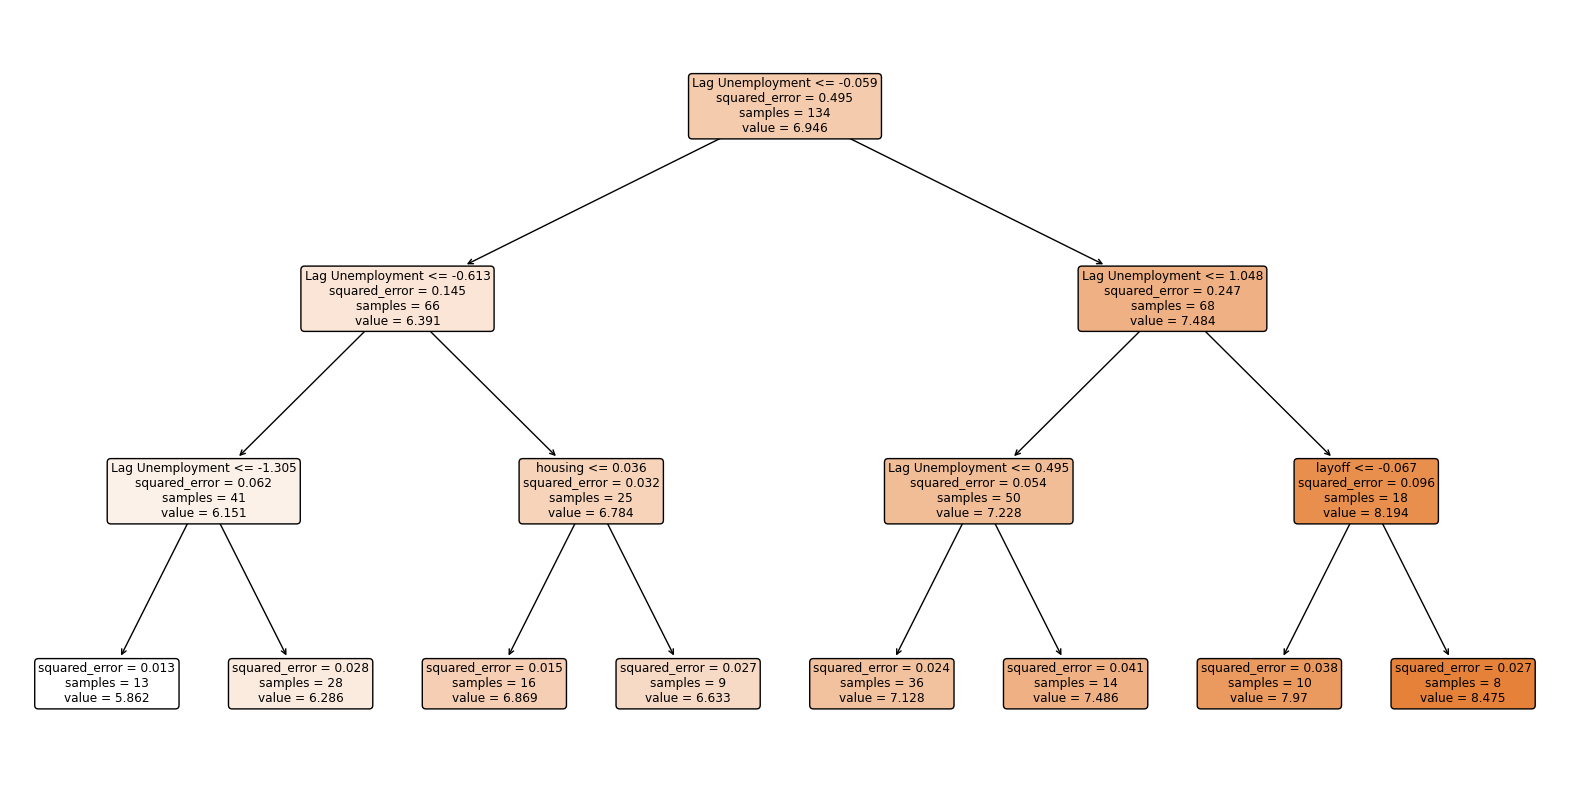

In [39]:
# 3a
matplotlib.rcParams['figure.figsize'] = (20, 10)
dtree = DecisionTreeRegressor(max_depth=3)
dtree.fit(X_train, y_train)
_ = plot_tree(dtree, 
              feature_names=feature_names,
              filled=True, rounded=True)

In [40]:
mean_squared_error(y_test, dtree.predict(X_test))

0.04590872993686362

<BarContainer object of 11 artists>

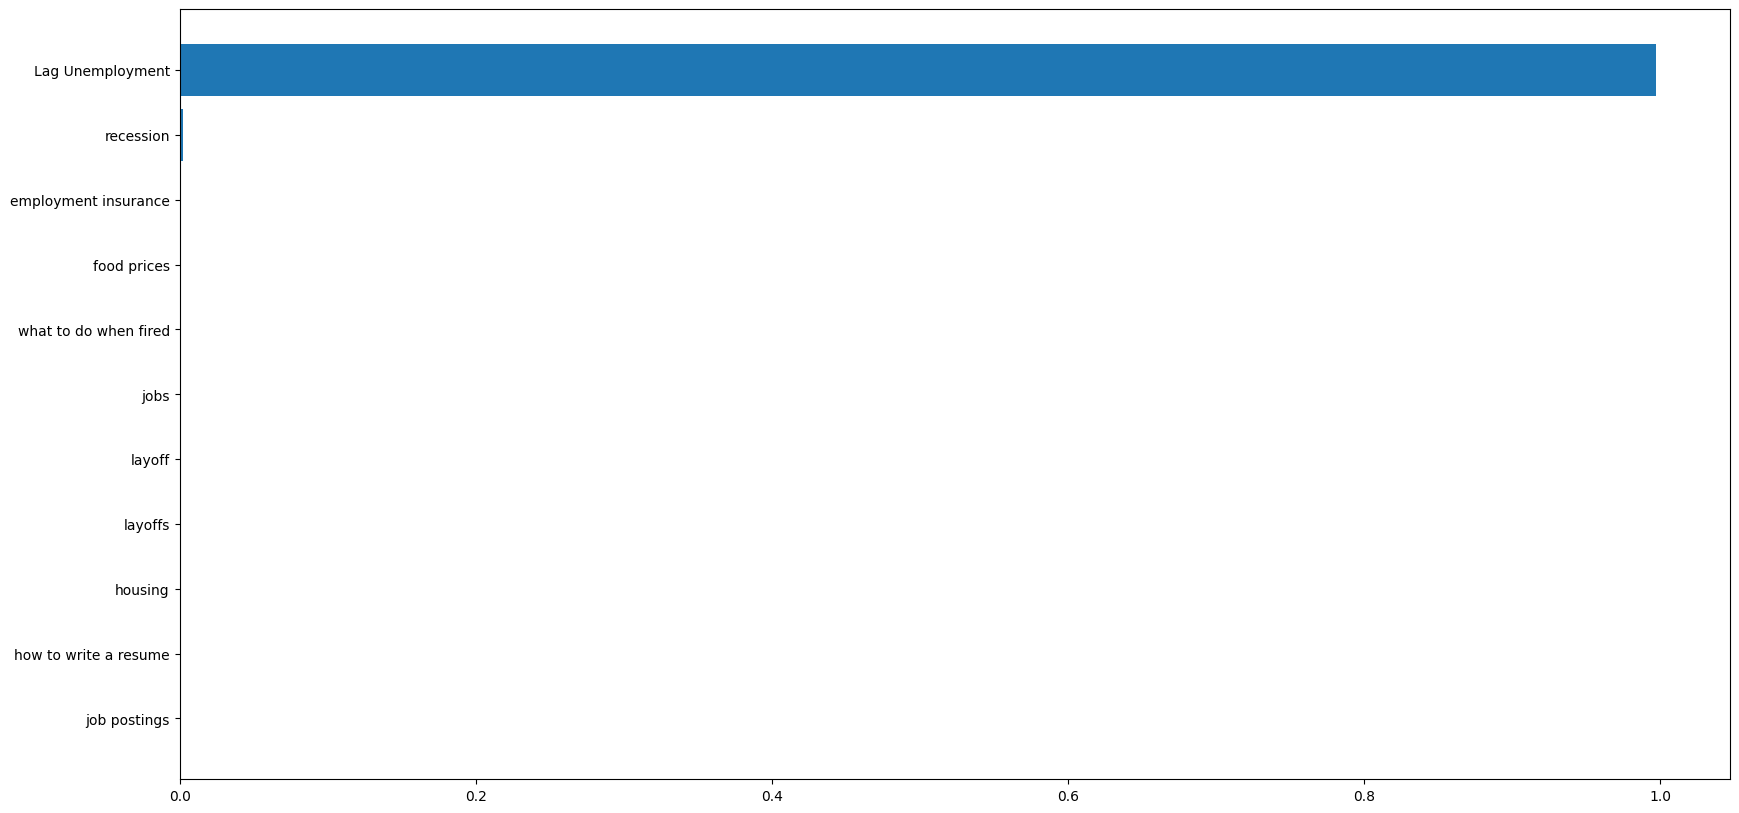

In [41]:
# 3b
rforest = RandomForestRegressor(max_depth=2)
rforest.fit(X_train, y_train)
simportances, snames = sort_lists([rforest.feature_importances_, feature_names])
plt.barh(snames, simportances)

In [42]:
mean_squared_error(y_test, rforest.predict(X_test))

0.04257426925872576

<BarContainer object of 11 artists>

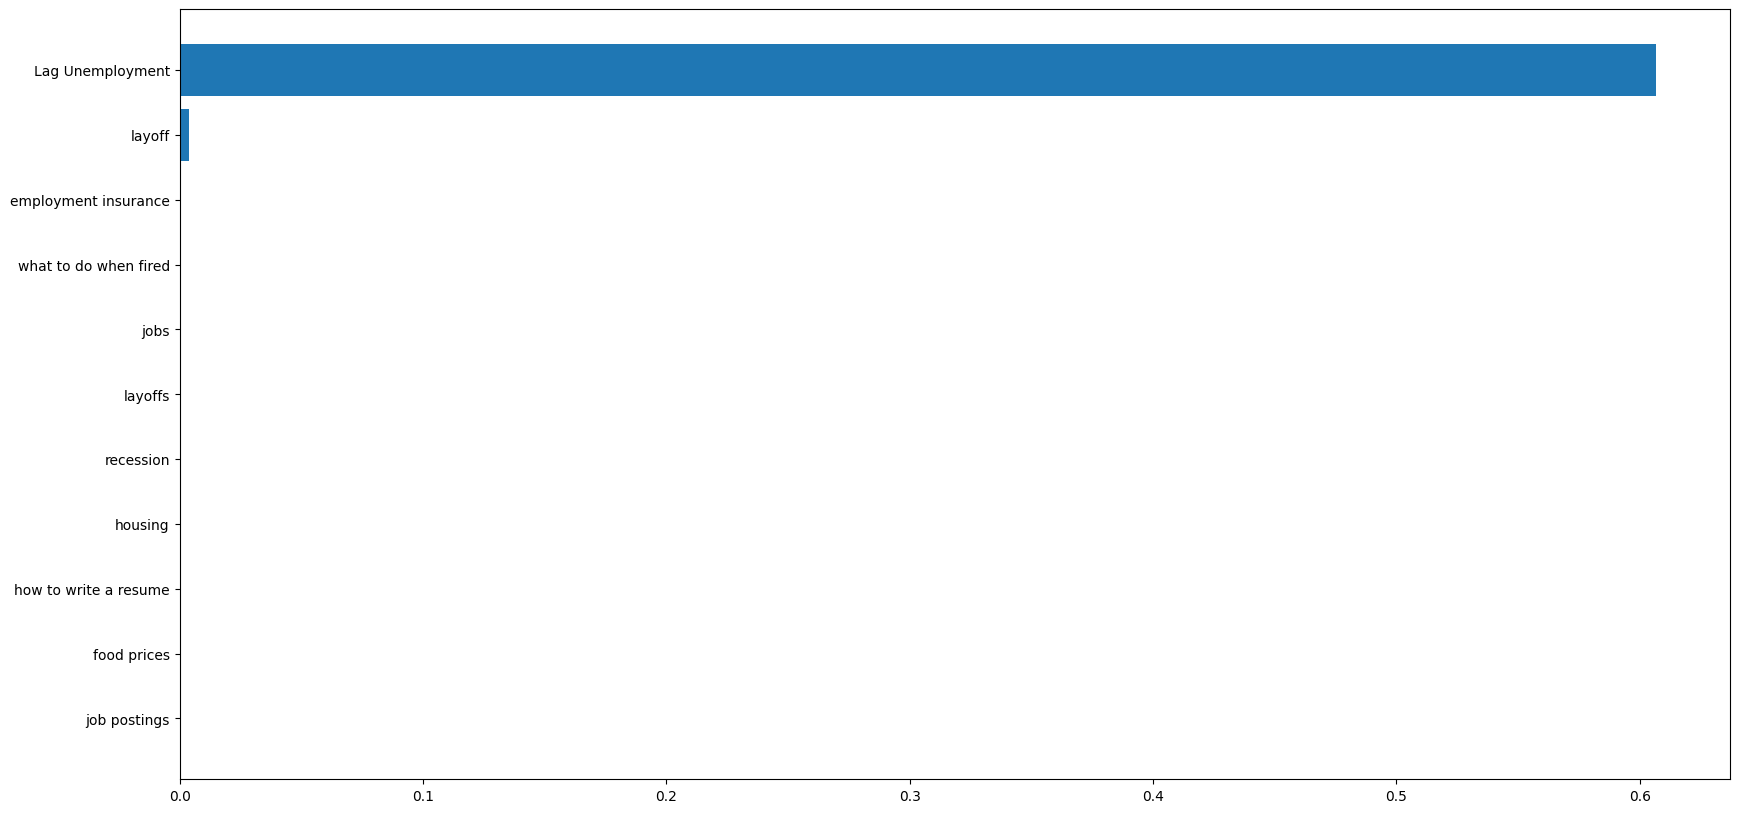

In [43]:
# 3c
rlin = Lasso(alpha=0.1)
rlin.fit(X_train, y_train)
coefs, cnames = sort_lists([rlin.coef_, feature_names])
plt.barh(cnames, coefs)

In [44]:
mean_squared_error(y_test, rlin.predict(X_test))

0.030942795661361457

In [45]:
# 4a

warnings.filterwarnings('ignore')

# CCP stands for Cost Complexity Pruning
models = [
    (dtree, "ccp_alpha", {"max_depth": 3}),
    (rforest, "ccp_alpha", {"max_depth": 2}),
    (rlin, "alpha", {}),
]

splitter = TimeSeriesSplit(n_splits=5, test_size=20, gap=2)
alpha_vals = [0] + list(0.25*(2**np.arange(8)))

dfs = []
for (model, alpha_name, default_params) in tqdm(models):    
    df, gs = mse_gs_cv(model, {alpha_name: alpha_vals}, X, y, cv=splitter)
    df.rename({"ccp_alpha": "alpha"}, axis=1, inplace=True)
    df["model"] = type(model).__name__
    dfs.append(df)
    
df = pd.concat(dfs, axis=0)
del dfs
df

100%|███████████████████████████| 3/3 [00:07<00:00,  2.55s/it]


,alpha,score,model
0,0,-0.143243,DecisionTreeRegressor
1,0.25,-0.406308,DecisionTreeRegressor
2,0.5,-0.491361,DecisionTreeRegressor
3,1.0,-0.391784,DecisionTreeRegressor
4,2.0,-0.391784,DecisionTreeRegressor
5,4.0,-0.391784,DecisionTreeRegressor
6,8.0,-0.391784,DecisionTreeRegressor
7,16.0,-0.391784,DecisionTreeRegressor
8,32.0,-0.391784,DecisionTreeRegressor
0,0,-0.086398,RandomForestRegressor


In [46]:
df.pivot(index="alpha", columns="model", values="score")

model,DecisionTreeRegressor,Lasso,RandomForestRegressor
alpha,,,
0.00,-0.143243,-0.017532,-0.086398
0.25,-0.406308,-0.070027,-0.263638
0.50,-0.491361,-0.221981,-0.307277
1.00,-0.391784,-0.391784,-0.393980
2.00,-0.391784,-0.391784,-0.393882
4.00,-0.391784,-0.391784,-0.387539
8.00,-0.391784,-0.391784,-0.390671
16.00,-0.391784,-0.391784,-0.392814
32.00,-0.391784,-0.391784,-0.393735
